<a href="https://colab.research.google.com/github/anaguilarar/WeatherSoilDataProcessor/blob/main/google_colab_examples/dssat_spatial_crop_simulation_pixel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anaguilarar/WeatherSoilDataProcessor.git

import os
os.chdir('/content/WeatherSoilDataProcessor')

!pip install -r /content/WeatherSoilDataProcessor/requirements.txt

Cloning into 'WeatherSoilDataProcessor'...
remote: Enumerating objects: 2239, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 2239 (delta 86), reused 77 (delta 25), pack-reused 2082 (from 2)
Receiving objects: 100% (2239/2239), 124.51 MiB | 16.95 MiB/s, done.
Resolving deltas: 100% (1773/1773), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rioxarray to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
!pip install hvplot panel param geoviews bokeh jupyter_bokeh -U
from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.3/170.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.3/547.3 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: panel
    Found existing installation: panel 1.

# Run spatial Crop Simulation using at pixel-scale resolution

In this example, we show how to simulate the potential yield of a specific crop at a fine spatial resolution (250m), aligned with the SoilGrids project resolution. The simulation requires detailed information on soil and weather conditions, as well as specified management practices.

## Repository Structure
The repository consists of three main components:

1. [**Download Spatial Data:**](#downloaddata)  
  - Weather Data
  - Soil Data

2. [**Data Cube Creation:**](#datacube)
  - Set configuration parameters
  - Spatial visualization
  - Export data as NetCDF files

3. [**Crop Modeling Using the DSSAT Model:**](#cropmodel)
  - Configuration file setup
  - Running DSSAT
  - Plotting the results

## 1. Download Spatial Data<a id="downloaddata"></a>



### Weather Data

In this section, we will download historical weather data . The information will be downloaded mainly from two sources [CHIRPS](https://www.chc.ucsb.edu/data/chirps) and [AgERA5](https://cds.climate.copernicus.eu/datasets/sis-agrometeorological-indicators?tab=overview).

To access AgERA5 data, users must provide account credentials. This requires two key pieces of information:

- Email – The email address used to register the AgERA5 account.
- API Code – A unique code available in the profile settings after account creation.

The following command is used to authenticate and access AgERA5 data:

In [ ]:
YOURUSERAPICODE = 'your_api_code'#
YOUREMAIL = 'your_email@example.com'

with open("/root/.cdsapirc", "w") as f:
  f.write("url: https://cds.climate.copernicus.eu/api\nkey: {}\nemail: ".format(YOURUSERAPICODE, YOUREMAIL))

After, we set the configuration dictionary that defines the parameters for the weather data download, such as the time period, geographical extent, and the output folder path.

In [ ]:
import os
os.chdir('/content/WeatherSoilDataProcessor')

import geopandas as gpd
from omegaconf import OmegaConf

from spatialdata.climate_data import MLTWeatherDataCube, ClimateDataDownload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {
    'DATES': {
        'starting_date':'2001-01-01',
        'ending_date': '2002-12-31'},
    'SPATIAL_INFO': {
          'spatial_file': 'data/country.shp',
          'extent': None #[-90, 12, -83, 17]
    },
    'WEATHER': { ## weather information
        'variables': { # variables to download
              'precipitation': {'mission': 'chirps', 'source': 'chips'},
              'solar_radiation': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmax': {'mission': 'agera5', 'source': 'agera5'},
              'temperature_tmin': {'mission': 'agera5', 'source': 'agera5'}
        },
    },
    'GENERAL': {
        'suffix': 'hnd',
        'ncores': 10,
    },
    'PATHS':{
        'output_path': 'weather/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': 'data/country.shp', 'extent': None}

In [ ]:
if config.SPATIAL_INFO.get('spatial_file',None):
    extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), round_numbers = True)
else:
    extent = config.SPATIAL_INFO.extent

print(f"from {config.DATES.starting_date} to {config.DATES.ending_date}" )
climatedata = ClimateDataDownload(starting_date= config.DATES.starting_date,
                                    ending_date= config.DATES.ending_date,
                                    xyxy= extent,
                                    output_folder= config.PATHS.output_path)

climatedata.download_weather_information(config.WEATHER.variables, suffix_output_folder=config.GENERAL.suffix, ncores = 0)

from 2001-01-01 to 2002-12-31
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.01.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.02.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.03.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.04.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.05.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.06.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.07.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.08.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/2001/chirps-v2.0.2001.01.09.cog
https://data.chc.ucsb.edu/products/CHIRPS-2.0/global_daily/cogs/p05/20

2025-03-25 15:16:53,958 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:16:53,960 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-25 15:16:53,966 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:16:53,968 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter nam

ae8716180277e3f6d22ba5b17d8f2a78.zip:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

39ff9469858bedd3b45d6ae7c0ffa248.zip:   0%|          | 0.00/12.8M [00:00<?, ?B/s]

Requested Year 2001 
 downloaded in weather/solar_radiation_hnd_raw/2001.zip
Requested Year 2002 
 downloaded in weather/solar_radiation_hnd_raw/2002.zip
2001 {'version': '1_1', 'area': [17, -90, 12, -83], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2001'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}
2002 {'version': '1_1', 'area': [17, -90, 12, -83], 'variable': ['2m_temperature'], 'statistic': ['24_hour_maximum'], 'year': ['2002'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-03-25 15:21:17,700 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:21:17,703 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-25 15:21:17,712 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:21:17,714 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter nam

799de7357c5b622bb8fcf273634b21dc.zip:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

Requested Year 2001 
 downloaded in weather/temperature_tmax_hnd_raw/2001.zip


2025-03-25 15:27:43,339 INFO status has been updated to successful
INFO:datapi.legacy_api_client:status has been updated to successful


919534e6aaa37903198f8c04a409c967.zip:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

Requested Year 2002 
 downloaded in weather/temperature_tmax_hnd_raw/2002.zip
2001 {'version': '1_1', 'area': [17, -90, 12, -83], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2001'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}
2002 {'version': '1_1', 'area': [17, -90, 12, -83], 'variable': ['2m_temperature'], 'statistic': ['24_hour_minimum'], 'year': ['2002'], 'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'], 'day': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']}


2025-03-25 15:27:46,194 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:27:46,197 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:27:46,199 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-25 15:27:46,207 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter nam

b8c5b20e2ba87500efbe5100e5f05372.zip:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

571bd6b43da28e4d665cafcc06c2e21e.zip:   0%|          | 0.00/12.4M [00:00<?, ?B/s]

Requested Year 2002 
 downloaded in weather/temperature_tmin_hnd_raw/2002.zip
Requested Year 2001 
 downloaded in weather/temperature_tmin_hnd_raw/2001.zip


### Soil Data

In this section, we will download soil data information for different depths. Currently the information is downloaded from [SoilGrids](https://soilgrids.org/) project.


In [ ]:
from spatialdata.soil_data import SoilGridDataDonwload
from spatialdata.gis_functions import get_boundaries_from_path

configuration_info = {

    'SPATIAL_INFO': {
          'spatial_file': 'data/country.shp',
          'extent': None, #[-90, 12, -83, 17],
          'crs': 'ESRI:54052' ## soilgrids proejection system
    },
    'SOIL': { ## weather information
          'variables': ["clay",  "sand", "silt", "wv0010","cec", "wv0033", "wv1500"],
          'depths': ["0-5","5-15","15-30","30-60"]
    },
    'GENERAL': {
        'suffix': 'hnd'
    },
    'PATHS':{
        'output_path': 'soil/'
    }
}

config = OmegaConf.create(configuration_info)
config.SPATIAL_INFO

{'spatial_file': 'data/country.shp', 'extent': None, 'crs': 'ESRI:54052'}

In [ ]:
if config.SPATIAL_INFO.get('spatial_file',None):
    extent = get_boundaries_from_path(config.SPATIAL_INFO.get('spatial_file',None), crs = config.SPATIAL_INFO.crs, round_numbers = True)
else:
    extent = config.SPATIAL_INFO.extent

outputpath = os.path.join(config.PATHS.output_path, config.GENERAL.suffix)

soildata = SoilGridDataDonwload(soil_layers= config.SOIL.variables,
                            depths= config.SOIL.depths,
                            output_folder= outputpath)

soildata.download_soilgrid(boundaries= extent)

File created: clay_0-5cm_mean.tif 
File created: clay_5-15cm_mean.tif 
File created: clay_15-30cm_mean.tif 
File created: clay_30-60cm_mean.tif 
File created: sand_0-5cm_mean.tif 
File created: sand_5-15cm_mean.tif 
File created: sand_15-30cm_mean.tif 
File created: sand_30-60cm_mean.tif 
File created: silt_0-5cm_mean.tif 
File created: silt_5-15cm_mean.tif 
File created: silt_15-30cm_mean.tif 
File created: silt_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_0-5cm_mean.tif


File created: wv0010_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_5-15cm_mean.tif


File created: wv0010_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_15-30cm_mean.tif


File created: wv0010_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0010/wv0010_30-60cm_mean.tif


File created: wv0010_30-60cm_mean.tif 
File created: cec_0-5cm_mean.tif 
File created: cec_5-15cm_mean.tif 
File created: cec_15-30cm_mean.tif 
File created: cec_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_0-5cm_mean.tif


File created: wv0033_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_5-15cm_mean.tif


File created: wv0033_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_15-30cm_mean.tif


File created: wv0033_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv0033/wv0033_30-60cm_mean.tif


File created: wv0033_30-60cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_0-5cm_mean.tif


File created: wv1500_0-5cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_5-15cm_mean.tif


File created: wv1500_5-15cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_15-30cm_mean.tif


File created: wv1500_15-30cm_mean.tif 
https://storage.googleapis.com/isric-share-soilgrids/pre-release/wv1500/wv1500_30-60cm_mean.tif


File created: wv1500_30-60cm_mean.tif 


## 2. Data Cube Creation<a id="datacube"></a>

### Set configuration parameters
To implement this, it is necessary to have spatial information for soil and climate. We can create a datacube with dimensions height, width, channel, and date for weather, and height, width, channel, and depth for soil.

An example of the spatial configuration is available in the options folder. Here, we will define it as a dictionary variable.

In [ ]:
from pathlib import Path
import sys

FILE_PATH = Path.cwd().joinpath('Py_DSSATTools')

sys.path.append(
    str(FILE_PATH.absolute())
)


In [ ]:
## creating
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialData

configuration_info = {
    'GENERAL_INFO': {'projected_crs':'ESRI:54052'},
    'SPATIAL_VECTOR': {
        'boundaries': "data/country.shp" # geo spatial file that will define the spatial boundaries
    },
    'WEATHER': { ## weather information
        'setup_parameters': { # parameters to create the datacube
            'paths':{ # path that allows each one of the meteorological variables information
                'precipitation': "weather/precipitation_hnd_raw",
                'srad': "weather/solar_radiation_hnd_raw",
                'tmax': "weather/temperature_tmax_hnd_raw",
                'tmin': "weather/temperature_tmin_hnd_raw"
            },
            'crs': 'EPSG:4326', ## spatial coordinates system
            'period': ['2001-01-01', '2001-12-31'] ,
            'reference_variable': 'precipitation' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    },
    'SOIL': {
        'setup_parameters': { # parameters to create the datacube
            'path': "soil/hnd/",
            'variables': ["bdod","clay","sand", "silt"],
            'depths': ["0-5","5-15","15-30","30-60"],
            'crs': 'ESRI:54052', ## SOILGRIDS spatial coordinates system
            'reference_variable': 'sand' # variable used as spatial resolution reference
        },
        'data_cube_path' : None # path to the data cube information if it was already created
    }
}

/content/WeatherSoilDataProcessor/Py_DSSATTools/DSSATTools/__init__.py:88: DeprecationWarning: DSSATTools version 3 is soon to be released. The new version is a major upgrade and will not be backwards compatible. This will be the latest release of DSSATTools version 2.
  warnings.warn(
/content/WeatherSoilDataProcessor/Py_DSSATTools/DSSATTools/__init__.py:88: DeprecationWarning: DSSATTools version 3 is soon to be released. The new version is a major upgrade and will not be backwards compatible. This will be the latest release of DSSATTools version 2.
  warnings.warn(


In [ ]:

# Initialize SpatialData with the configuration dictionary
spdata = SpatialData(configuration_dict=configuration_info)

# Retrieve climate data
spdata.get_climate_data()

# Retrieve soil data
spdata.get_soil_data()

weather/precipitation_hnd_raw/2001
weather/solar_radiation_hnd_raw/2001
weather/temperature_tmax_hnd_raw/2001
weather/temperature_tmin_hnd_raw/2001


100%|██████████| 365/365 [00:00<00:00, 1070.46it/s]


there is not data for this variable bdod


100%|██████████| 4/4 [00:10<00:00,  2.51s/it]


PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
PROJCS["Interrupted_Goode_Homolosine",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]

100%|██████████| 4/4 [00:00<00:00, 1037.10it/s]


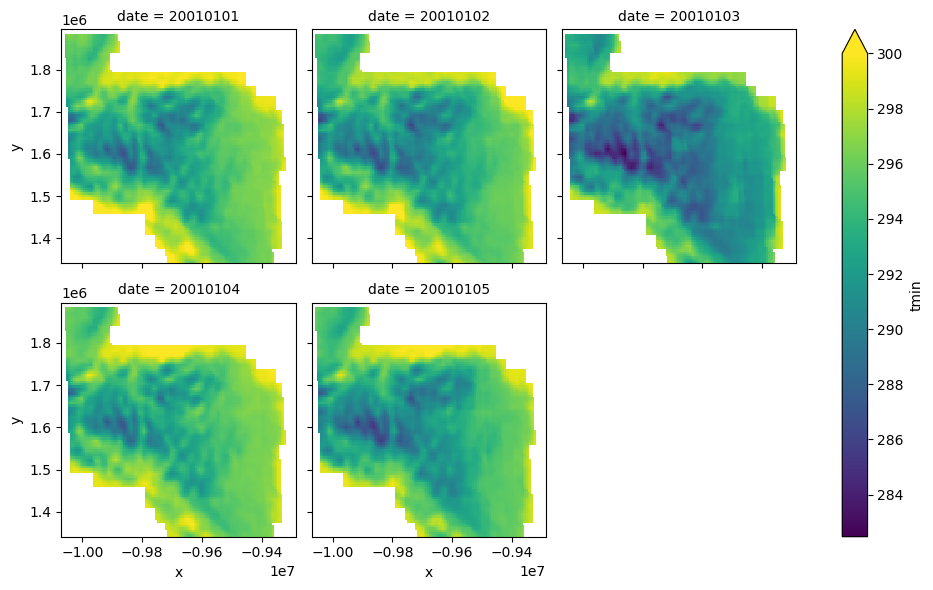

In [ ]:
## plots

g_simple = spdata.climate.tmin.isel(date = list(range(5))).plot(x="x", y="y", col="date", col_wrap=3, vmax = 300)

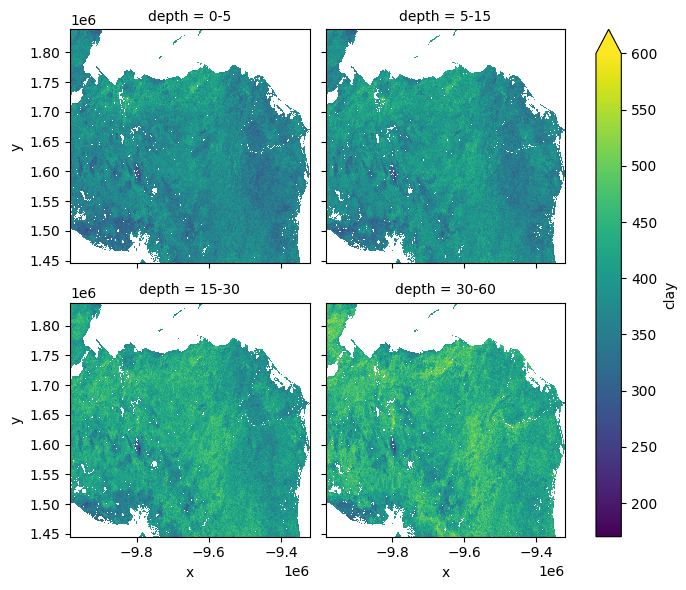

In [ ]:
# texture values in soil grids data is multiply by 10
g_simple = spdata.soil.clay.plot(x="x", y="y", col="depth", col_wrap=2, vmax = 600)

In [ ]:
# save data as datacubes
spdata._save_asnc(spdata.soil, fn = 'soil/soil_hnd.nc')
spdata._save_asnc(spdata.climate, fn = 'weather/weather_hnd.nc')

## 3. Crop Modeling Using the DSSAT Model<a id="cropmodel"></a>




### Spatial data

The previous steps serve as a guide for obtaining the spatial datacubes data, (climate, and weather). In the following example, we will use datacubes that were previously processed for the entire country. These files contain historical climate data spanning a 34-year period. They are available in a Google Drive folder, so you will only need to download them using the gdown function.


In [8]:
soil_fileid = '1-zibd97Cr1LcPvrrv0ICZur1SWU_WVCn'
weather_fileid = '1AoEy49mcuBUS8fs4OFdNEH4E90A33LKD'

if not os.path.exists('hnd_soilgrids.nc'):
  !gdown --id {soil_fileid} --output hnd_soilgrids.nc

if not os.path.exists('hnd_weather.nc'):
  !gdown --id {weather_fileid} --output hnd_weather.nc

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=drive/folders/1_tsGWzbrWGHZXoBrSP7fdlrXDykWRJed

but Gdown can't. Please check connections and permissions.


### Configuration file setup

To specify that the analysis will be done at pixel-scale, we set 'pixel' in the configuration dictionary.

Other parameters to configure include crop parameters and management practices.
Below is an example of how to define these parameters. For more examples, please check the options/dssat_options folder.

In [1]:
import os
os.chdir('/content/WeatherSoilDataProcessor')
from crop_modeling.spatial_process import SpatialCM
import numpy as np
import pandas as pd

cm_configuration = {
    'GENERAL_INFO': {
        'country': 'Honduras',
        'country_code': 'HND', # crountry code
        'working_path': 'runs', # the model outputs will be located in this path
        'ncores': 10,
        'model': 'dssat',
        'bin_path': None
    },
    'SPATIAL_INFO':{
        'geospatial_path': '/content/WeatherSoilDataProcessor/data/hnd_olancho_valley.shp', # spatial file that contains the region of interest
        'feature_name': 'GEOCODIGO', ## an unique code that represent each region of interest
        'aggregate_by' : 'pixel',
        'soil_path' : 'hnd_soilgrids.nc',
        'weather_path': 'hnd_weather.nc',
        'scale_factor': 10 # scale factor for soil and weather spatial resolution combination
    },
    'CROP': {
        'name': 'Maize', # crop name
        'cultivar': 'IB1072', # cultivar
        'cultivar_file': None # optional for the cases that you have a cultivar that is not in DSSATTools default cultivars
    },
    'MANAGEMENT':{
        'planting_date': '1991-03-01',
        'harvesting_date': None,
        'plantingWindow': 30, # planting window in weeks
        'fertilizer_schedule': {
            'days_after_planting': None,
            'npk': None
        },
        'index_soilwat': 1,
        'template': 'crop_modeling/dssat/exp_files/KEAG8104.MZX'
    }
}



/usr/local/lib/python3.11/dist-packages/DSSATTools/__init__.py:88: DeprecationWarning: DSSATTools version 3 is soon to be released. The new version is a major upgrade and will not be backwards compatible. This will be the latest release of DSSATTools version 2.
  warnings.warn(


### Running DSSAT

In [3]:
# Initialize the spatial crop modeling class
cm_sp = SpatialCM(configuration_dict=cm_configuration)
geocode = '150149'
# Specify the region of interest by its geocode this can be also done using the feature index
roi = cm_sp.geo_features.loc[cm_sp.geo_features['GEOCODIGO']==str(geocode)]
roi_name = roi[cm_sp.config.SPATIAL_INFO.feature_name].values[0]
roi
#cm_sp.geo_features['GEOCODIGO']

loaded from hnd_soilgrids.nc
loaded from hnd_weather.nc


,GEOCODIGO,ALDEA,COD_ALDEA,COD_MUNI,COD_DEPTO,KM2,DENSIDAD,MUNI,DEPTO,AREA_HA,geometry
0,150149,Pusunca o San Agustín,150149,1501,15,20.8814,51.0981,Juticalpa,Olancho,2088.138366,"POLYGON ((-86.00823 14.70097, -86.0082 14.7007..."


In [4]:

import shutil
if os.path.exists(f'/content/WeatherSoilDataProcessor/runs/{geocode}'):
  shutil.rmtree(f'/content/WeatherSoilDataProcessor/runs/{geocode}', ignore_errors=False, onerror=None)

In [ ]:
cm_sp.set_up_folders(site = roi_name)

# Create soil and weather files for the selected region
workingpath = cm_sp.create_roi_sp_data(
    roi= roi,
)
if workingpath is not None:
    # Locate environmental working paths
    cm_sp.model.find_envworking_paths(cm_sp._tmp_path, 'WTH')

    # Set up crop files
    cm_sp.model.set_up_crop(crop=cm_sp.crop, cultivar=cm_sp.cultivar)

    # Set up management files
    cm_sp.model.set_up_management(crop=cm_sp.crop, cultivar=cm_sp.cultivar, **cm_sp.config.MANAGEMENT)

    # run the simulation
    dssath_path = cm_sp.config.GENERAL_INFO.get('dssat_path', None)
    completed_sims =cm_sp.model.run(cm_sp.model.crop_code, crop=cm_sp.crop,planting_window=cm_sp.config.MANAGEMENT.plantingWindow,
                                        bin_path = cm_sp.config.GENERAL_INFO.bin_path, remove_tmp_folder=True)
    print(completed_sims)
else:
    print('there is no information')

100%|██████████| 1049/1049 [18:30<00:00,  1.06s/it]


Configuration file written: runs/150149/1254/experimental_file_config.yaml
experimental file created: ['runs/150149/1254/EXPS0001.MZX']
Configuration file written: runs/150149/1571/experimental_file_config.yaml
experimental file created: ['runs/150149/1571/EXPS0001.MZX']
Configuration file written: runs/150149/1440/experimental_file_config.yaml
experimental file created: ['runs/150149/1440/EXPS0001.MZX']
Configuration file written: runs/150149/707/experimental_file_config.yaml
experimental file created: ['runs/150149/707/EXPS0001.MZX']
Configuration file written: runs/150149/1865/experimental_file_config.yaml
experimental file created: ['runs/150149/1865/EXPS0001.MZX']
Configuration file written: runs/150149/1264/experimental_file_config.yaml
experimental file created: ['runs/150149/1264/EXPS0001.MZX']
Configuration file written: runs/150149/592/experimental_file_config.yaml
experimental file created: ['runs/150149/592/EXPS0001.MZX']
Configuration file written: runs/150149/541/experime

  6%|▌         | 59/1047 [17:44<4:55:38, 17.95s/it]

### Crop simulation outputs

After completing the simulation, the next step is to generate the output maps.


In [5]:
from crop_modeling.dssat.output import update_dssat_data_using_path
from crop_modeling.spatial_process import create_mlt_yield_raster
import rioxarray as rio
import matplotlib.pyplot as plt


refraster = rio.open_rasterio(os.path.join(cm_sp._tmp_path,'ref_raster.tif'))
model_data = update_dssat_data_using_path(cm_sp._tmp_path)

mlt_pot_yield = create_mlt_yield_raster(refraster, model_data, ycol_name='HWAH')


100%|██████████| 990/990 [00:03<00:00, 269.03it/s]


### Plotting the results

In [6]:
import hvplot.xarray
import holoviews as hv
import panel as pn

hv.extension("bokeh")
minlim = mlt_pot_yield.HWAH.min().values
maxlim = mlt_pot_yield.HWAH.max().values

mltmap = mlt_pot_yield.HWAH.hvplot.image(x='x', y='y', groupby = 'date',frame_height = 600, frame_width= 400, cmap='YlGnBu', fontscale=1.6, crs='EPSG:4326', tiles = 'EsriImagery', clim=(minlim,maxlim))

dmap_panel = pn.panel(mltmap)
dmap_panel


Row
    [0] HoloViews(DynamicMap, sizing_mode='fixed')
    [1] WidgetBox(align=('end', 'start'))
        [0] DiscreteSlider(name='date', options={'1991-03-01 00:00:00': np...}, value=np.datetime64('1991-03-01T...)

### Exporting the results

In [7]:
from crop_modeling.utils.process import get_crs_fromxarray,set_encoding, check_crs_inxrdataset

dcengine = 'netcdf4'
encoding = set_encoding(mlt_pot_yield)
xrdata = check_crs_inxrdataset(mlt_pot_yield)
xrdata.to_netcdf(f'simlations_{geocode}.nc', encoding = encoding, engine = dcengine)



In [8]:
import hvplot.pandas
boxplot = mlt_pot_yield.HWAH.hvplot.box('HWAH', by=['date'], rot=90, box_fill_color='lightblue', width=1600, height=450).opts(ylim=(1285,9969))
dmap_panel = pn.panel(boxplot)
dmap_panel

HoloViews(BoxWhisker, height=450, sizing_mode='fixed', width=1600)

In [5]:
from crop_modeling.utils.output_transforms import summarize_spatial_yields_by_time_window

summ_yield  =summarize_spatial_yields_by_time_window(data, plantingWindow= 30)
